In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint

import torch
import pickle
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import glob

from pose_est import brute_force_pose_est
import postprocess_dataset
from utils import utils

In [5]:
# displays meshes at the predicted pose
def show_meshes(input_dir_img, input_dir_mesh, meshes_group_name="", use_meshes=None):
    pred_poses_path = os.path.join(input_dir_mesh, "pred_poses.p")
    cached_pred_poses = pickle.load(open(pred_poses_path, "rb"))

    for instance_name in cached_pred_poses:
        if use_meshes is None or instance_name in use_meshes:
            input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
            with torch.no_grad():
                mesh_original = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                mesh_processed = utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+"_{}.obj".format(meshes_group_name)), device)

            # rendering original and processed mesh at predicted pose
            pred_dist = cached_pred_poses[instance_name]['dist']
            pred_elev = cached_pred_poses[instance_name]['elev']
            pred_azim = cached_pred_poses[instance_name]['azim']
            R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
            mesh_original_render = utils.render_mesh(mesh_original, R, T, device)
            mesh_processed_render = utils.render_mesh(mesh_processed, R, T, device)

            # visualizing
            print(instance_name)
            fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
            ax[0][0].imshow(input_image)
            ax[0][0].xaxis.set_visible(False)
            ax[0][0].yaxis.set_visible(False)

            ax[0][1].imshow(mesh_original_render[0, ..., :3].cpu().numpy())
            ax[0][1].xaxis.set_visible(False)
            ax[0][1].yaxis.set_visible(False)

            ax[0][2].imshow(mesh_processed_render[0, ..., :3].cpu().numpy())
            ax[0][2].xaxis.set_visible(False)
            ax[0][2].yaxis.set_visible(False)
            plt.pause(0.05)

In [11]:
#img_path = "data/test_dataset/0001old.png"
#mesh_path = "data/test_dataset/0001old.obj"
img_path = 'data/img_pix3d_chair/chair/2563.png'
mesh_path = 'data/onet_chair_pix3d_dann_simplified/2563.obj'


gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
mask = np.asarray(Image.open(img_path))[:,:,3] > 0
with torch.no_grad():
    mesh = utils.load_untextured_mesh(mesh_path, device)

pred_azim, pred_elev, pred_dist, renders = brute_force_pose_est.brute_force_estimate_pose(mesh, mask, 20, 20, 40, device, 8)

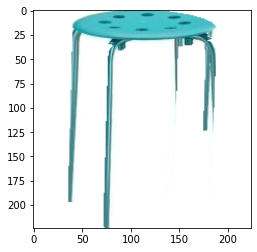

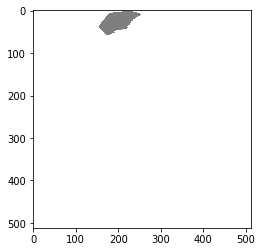

In [12]:
R, T = look_at_view_transform(pred_dist, pred_elev, pred_azim)
mesh_original_render = utils.render_mesh(mesh, R, T, device)
plt.imshow(Image.open(img_path))
plt.show()
plt.imshow(mesh_original_render[0, ..., :3].cpu().numpy())

In [ ]:
from 